In [81]:
import sys
sys.path.append("../../../marineHeatWaves/")
sys.path.append("../physiology/")

import marineHeatWaves as mh


from tpc import tpc

import xarray as xr
import numpy as np
import zarr

import pandas as pd

import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from string import ascii_uppercase

from functools import partial

from dask.distributed import Client

import cloudpickle

import gcsfs
import s3fs 
import boto3

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

%matplotlib inline

# **Figure**: Latitutinal + Seasonal Patterns of Performance Ratio by Isolate

In [82]:
isolates = pd.read_csv(
    "../../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv",
    engine='python'
)
isolates = isolates[
    (isolates.habitat == 'marine') & 
    (isolates.curvequal == 'good')
]

In [83]:
len(isolates)

96

In [84]:
len(isolates.dropna(subset=['isolation.latitude', 'isolation.longitude'], axis=0))

89

In [85]:
mhwPerformance_aggregated = pd.read_csv(
    "../isolate_performance_withnegative.csv"
)

In [86]:
mhwPerformance_aggregated.head()

,Unnamed: 0,lat,lon,isolate,mhw,detriment_sum,relative_detriment_mean,detriment_mean,performance_diff_mean,performance_diff_unscaled_mean,...,intensity_mean,duration,start_doy,peak_doy,current_year_sst_mean,start_date,peak_date,perf_det_ratio,latbin,doy_bins
0,0,-74.875,164.625,1,4.0,3.433027,1.303966,0.429128,0.237193,0.078059,...,1.297811,9.0,1,1,-1.202301,1986-12-31,536457600000000000,0.846135,"(-75.026, -59.75]","(0.639, 91.25]"
1,1,-74.875,164.625,1,5.0,6.265167,1.269172,0.417678,0.287250,0.094533,...,1.528319,16.0,21,32,-1.103370,1987-01-21,539136000000000000,0.815611,"(-75.026, -59.75]","(0.639, 91.25]"
2,2,-74.875,164.625,1,11.0,9.585366,1.713322,0.563845,0.035686,0.011744,...,0.187730,18.0,232,244,-1.168743,1988-08-19,588988800000000000,0.979598,"(-75.026, -59.75]","(181.5, 271.75]"
3,3,-74.875,164.625,1,14.0,10.139295,1.711648,0.563294,0.033256,0.010944,...,0.174102,19.0,196,201,-1.181397,1989-07-15,616896000000000000,0.980941,"(-75.026, -59.75]","(181.5, 271.75]"
4,4,-74.875,164.625,1,37.0,6.210158,1.715494,0.564560,0.029738,0.009786,...,0.156030,12.0,215,220,-1.219370,1995-08-03,807840000000000000,0.982961,"(-75.026, -59.75]","(181.5, 271.75]"


In [87]:
len(mhwPerformance_aggregated)

5299

In [88]:
## remove seasonality: 
mhwPerformance_aggregated.loc[
    mhwPerformance_aggregated.lat.between(-90, 0), 
    'peak_doy'
] = (mhwPerformance_aggregated.loc[mhwPerformance_aggregated.lat.between(-90, 0), 'peak_doy'] - 180) % 365

mhwPerformance['season']
mh= 
                    mutate(season = 
                           case_when(
                                (between(peak_doy, 0, 77) | between(peak_doy, 355, 366)) ~ "winter", # January 1 - March XX or December XX - December 31
                                between(peak_doy, 78, 170) ~ "spring", # March XX - June XX
                                between(peak_doy, 171, 295) ~ "summer", # June XX - September XX
                                between(peak_doy, 296, 354) ~ "fall" # September XX - December XX
                        )
                    )

In [89]:
def get_season(doy):
    if   (0 <= doy <= 77) or (355 <= doy <= 366): return "Winter"
    elif (78 <= doy <= 170): return "Spring"
    elif (171 <= doy <= 295): return "Summer"
    elif (296 <= doy <= 354): return "Fall"

In [90]:
mhwPerformance_aggregated['season'] = mhwPerformance_aggregated.peak_doy.apply(get_season)

In [91]:
mhwPerformance_aggregated[['peak_doy', 'season']].head()

,peak_doy,season
0,186,Summer
1,217,Summer
2,64,Winter
3,21,Winter
4,40,Winter


In [92]:
mhw_isolates_season_groups = mhwPerformance_aggregated.groupby(['isolate', 'season'])

In [93]:
mhw_isolates_season = pd.concat(
    [
        mhw_isolates_season_groups.mean().add_suffix("_mean"),
        mhw_isolates_season_groups.std().add_suffix("_std"),
        mhw_isolates_season_groups.count().iloc[:, 0].rename("value_count")
    ], 
    axis=1
)

In [94]:
mhw_isolates_season = mhw_isolates_season.reset_index()

In [95]:
mhw_isolates_season.head()

,isolate,season,Unnamed: 0_mean,lat_mean,lon_mean,mhw_mean,detriment_sum_mean,relative_detriment_mean_mean,detriment_mean_mean,performance_diff_mean_mean,...,performance_ratio_mean_std,intensity_cumulative_std,intensity_mean_std,duration_std,start_doy_std,peak_doy_std,current_year_sst_mean_std,peak_date_std,perf_det_ratio_std,value_count
0,1,Fall,2667.818182,-74.875,164.625,59.045455,5.166757,1.719705,0.565946,0.025369,...,0.005138,0.855214,0.019928,4.475281,18.671285,18.122539,0.062820,2.939128e+17,0.002198,22
1,1,Spring,2217.047619,-74.875,164.625,53.619048,5.285952,1.697535,0.558650,0.037930,...,0.010337,1.571112,0.037326,6.852876,22.345768,23.547621,0.062197,2.952811e+17,0.004128,21
2,1,Summer,2823.838710,-74.875,164.625,44.612903,4.360892,1.467554,0.482964,0.153807,...,0.176174,8.335614,0.499720,5.626932,127.385293,36.956499,0.060458,3.478839e+17,0.060323,31
3,1,Winter,2040.142857,-74.875,164.625,51.607143,4.789443,1.712879,0.563699,0.033507,...,0.005101,0.908677,0.019591,4.434712,24.365032,63.812639,0.056747,2.670511e+17,0.002195,28
4,3,Fall,2590.800000,-66.375,110.375,39.733333,3.222262,1.634974,0.347560,0.029417,...,0.005335,0.822281,0.012887,6.017435,15.426631,15.412425,0.022457,1.878084e+17,0.002143,15


In [96]:
import statsmodels.api as sm
import scipy

In [97]:
def smooth(x, y, xgrid):
    samples = np.random.choice(len(x), 10, replace=True)
    y_s = y.iloc[samples]
    x_s = x.iloc[samples]
    y_sm = sm.nonparametric.lowess(y_s,x_s, frac=1./5., it=5,
                     return_sorted = False)
    # regularly sample it onto the grid
    y_grid = scipy.interpolate.interp1d(x_s, y_sm, 
                                        fill_value='extrapolate')(xgrid)
    return y_grid

<Figure size 900x600 with 0 Axes>

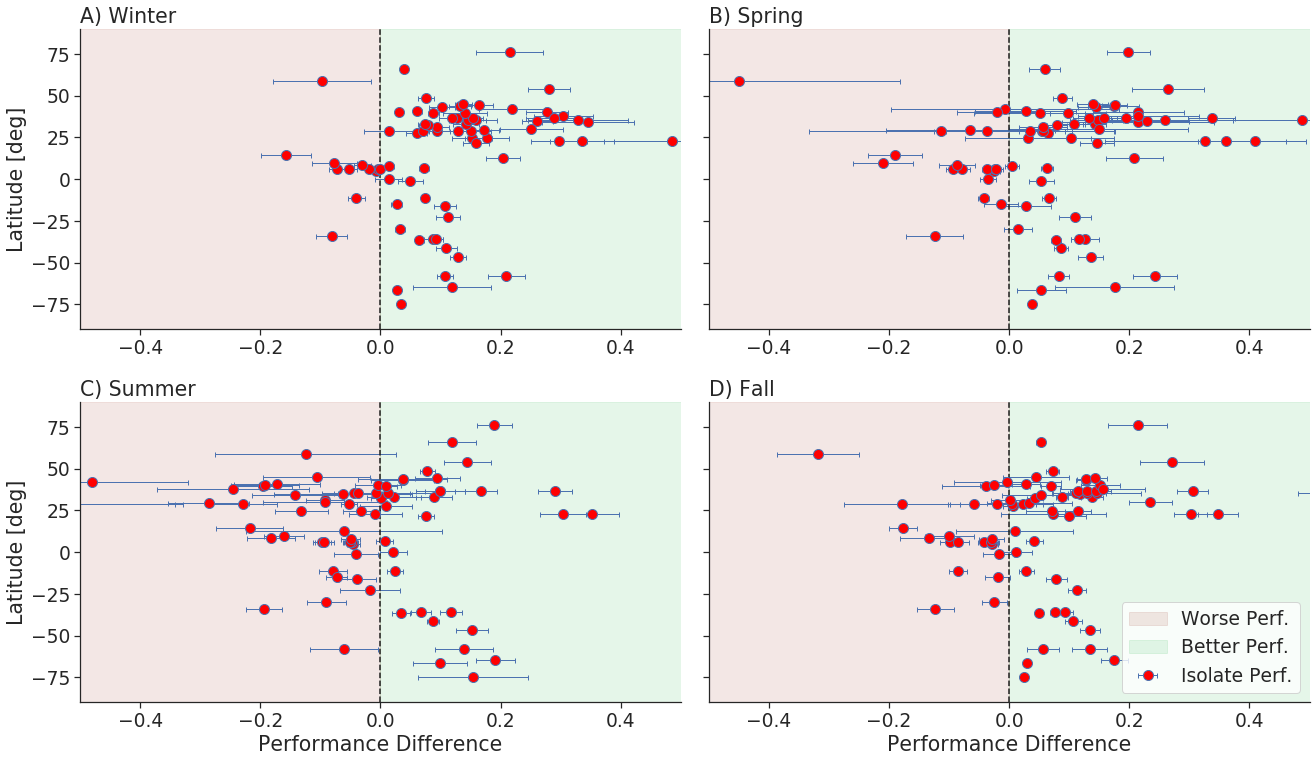

In [100]:
col_order = ["Winter", "Spring", "Summer", "Fall",]
sns.set(style='ticks', font_scale=1.7)
fig = plt.figure(dpi=150)
fg = sns.FacetGrid(
    mhw_isolates_season,
    col='season', col_wrap=2,
    height=5.5, aspect=1.7,
    sharex=False, col_order=col_order
)
fg.map(
    lambda x, y, err, color, **kwargs: plt.errorbar(x, y, xerr=err, **kwargs),
     'performance_diff_mean_mean', 'lat_mean', 'performance_diff_mean_std', 
    fmt='o', capsize=2.5, linewidth=1, ms=10, mfc='red', label='Isolate Perf.'
)
def title_ax(season, color):
    ax = plt.gca()
    season = season.iloc[0]
    facet_label = ascii_uppercase[col_order.index(season)]
    
#     ax.annotate(f"{facet_label}) {season}", (0.04, 0.04), fontsize=20, xycoords='axes fraction'),
    ax.set_title(f"{facet_label}) {season}", loc='left')

fg.map(
    title_ax,
    'season'
)


fg.map(lambda color: plt.gca().axvline(0, linestyle='--', color='k'))

# fg.fig.suptitle('Performance Ratio by Latitude', y = 1.03, x=0.5, ha='center')
fg.set(ylim=[-90, 90])
fg.set(xlim=[-0.5, 0.5])

fg.map(lambda color: plt.gca().axvspan(-0.5, 0, color='xkcd:brick red', alpha=0.1, label=r'Worse Perf.'))
fg.map(lambda color: plt.gca().axvspan(0, 0.5, color='xkcd:kelly green', alpha=0.1, label=r'Better Perf.'))

fg.set_titles("")
fg.set_ylabels("Latitude [deg]")
fg.set_xlabels("Performance Difference")

fg.axes[3].legend(loc='lower right')
plt.tight_layout()


plt.savefig("isolate_performance_seasonal.png", dpi=300, bbox_inches='tight')

In [79]:
len(mhw_isolates_season)

300

-- Some Stats

In [80]:
mhw_isolates_season.loc[mhw_isolates_season.lat_mean.between(-30, 30), 'Region'] = "Tropics"
mhw_isolates_season.loc[mhw_isolates_season.lat_mean.between(-60, -90), 'Region'] = "Poles"
mhw_isolates_season.loc[mhw_isolates_season.lat_mean.between(60, 90), 'Region'] = "Poles"
mhw_isolates_season.loc[mhw_isolates_season.lat_mean.between(-60, -30, inclusive=False), 'Region'] = "Mid. S"
mhw_isolates_season.loc[mhw_isolates_season.lat_mean.between(30, 60, inclusive=False), 'Region'] = "Mid. N"




In [34]:
regional_agg = mhw_isolates_season.groupby(['isolate', "Region"]).mean().reset_index().dropna()

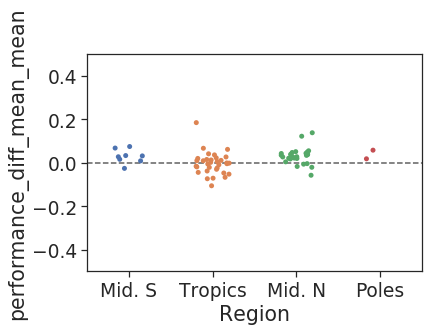

In [42]:

# sns.boxplot(x='Region', y='performance_ratio_mean_mean',  data=regional_agg,boxprops=dict(facecolor=(0,0,0,0)), width=0.5)
ax = sns.stripplot(x='Region',  y='performance_diff_mean_mean', data=regional_agg,jitter=0.2, alpha=1,)
ax.set_ylim([-0.5, 0.5])
ax.axhline(0.0, color='k', linestyle='--', alpha=0.7, zorder=-1)

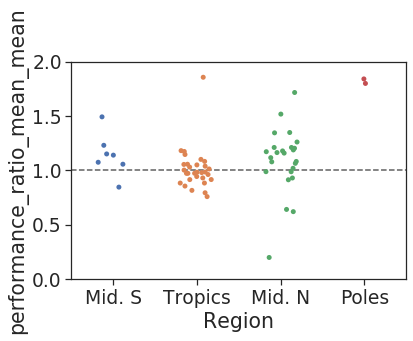

In [36]:
# sns.boxplot(x='Region', y='performance_ratio_mean_mean',  data=regional_agg,boxprops=dict(facecolor=(0,0,0,0)), width=0.5)
ax = sns.stripplot(x='Region',  y='performance_ratio_mean_mean', data=regional_agg,jitter=0.2, alpha=1,)
ax.set_ylim([0, 2])
ax.axhline(1.0, color='k', linestyle='--', alpha=0.7, zorder=-1)

In [37]:
mhw_isolates_season[mhw_isolates_season.Region =='Poles']

,isolate,season,Unnamed: 0_mean,lat_mean,lon_mean,mhw_mean,detriment_sum_mean,relative_detriment_mean_mean,detriment_mean_mean,performance_diff_mean_mean,...,intensity_cumulative_std,intensity_mean_std,duration_std,start_doy_std,peak_doy_std,current_year_sst_mean_std,peak_date_std,perf_det_ratio_std,value_count,Region
232,358,Fall,2059.444444,66.125,2.125,55.222222,5.929533,0.857189,0.436179,0.013566,...,10.830186,0.112378,10.760008,103.758266,15.851744,0.167294,1.328373e+17,0.008639,9,Poles
233,358,Spring,2907.611111,66.125,2.125,31.277778,3.322993,0.879717,0.447643,0.015206,...,6.927957,0.377666,4.218307,28.286813,28.880869,0.232836,1.990560e+17,0.029765,18,Poles
234,358,Summer,2718.520000,66.125,2.125,27.760000,4.303654,0.641637,0.326496,0.030584,...,32.489639,0.466090,12.887720,36.724560,35.112771,0.288060,2.782420e+17,0.059677,25,Poles
235,358,Winter,2957.277778,66.125,2.125,40.611111,4.446098,0.925791,0.471087,0.010164,...,6.495188,0.081048,6.002178,106.445927,125.650308,0.229182,1.539019e+17,0.003907,18,Poles
236,363,Fall,2590.100000,76.375,-74.625,45.250000,2.608693,0.504772,0.278059,0.059793,...,8.142300,0.257631,4.957451,18.834179,17.951396,0.284309,2.932912e+17,0.055013,20,Poles
237,363,Spring,3245.761905,76.375,-74.625,41.571429,2.866442,0.535855,0.295182,0.055466,...,6.450264,0.324442,5.782156,24.723615,23.695991,0.286227,3.496269e+17,0.094300,21,Poles
238,363,Summer,2438.080000,76.375,-74.625,52.840000,0.833230,0.159755,0.088003,0.053154,...,26.530835,0.751819,10.624186,36.038174,33.858382,0.231478,2.371295e+17,0.230156,25,Poles
239,363,Winter,2298.760000,76.375,-74.625,43.480000,3.297748,0.608771,0.335348,0.059995,...,9.508859,0.319262,6.254865,23.248082,69.288094,0.281540,3.128861e+17,0.070984,25,Poles


In [38]:
mhwPerformance_aggregated.groupby('isolate').count().mhw.describe()

count     75.000000
mean      70.653333
std       11.686783
min       37.000000
25%       63.000000
50%       69.000000
75%       77.000000
max      102.000000
Name: mhw, dtype: float64

In [39]:
len(mhwPerformance_aggregated.isolate.unique())

75